In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import re

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [33]:
train_data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test_data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
data_dictionary = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')
sample_submission = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')

In [34]:
train_data.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [35]:
!pip install lifelines

In [36]:
from lifelines import KaplanMeierFitter

def transform_survival_probability(train_data, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(train_data[time_col], train_data[event_col])
    

    y = kmf.survival_function_at_times(train_data[time_col]).values
    
    # Adjust for censoring
    # censored_mask = df[event_col] == 0
    #y[censored_mask] = y[censored_mask] * 1.2  # Increase survival prob for censored
    
    return y

train_data["y"] = transform_survival_probability(train_data, time_col='efs_time', event_col='efs')

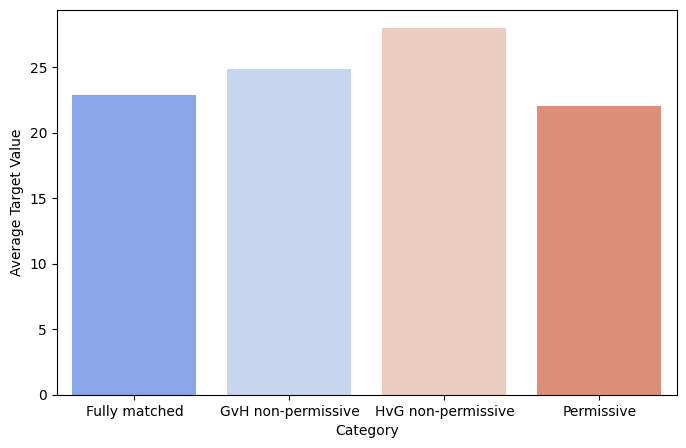

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

grouped_data = train_data.groupby('tce_match')['efs_time'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='tce_match', y='efs_time', data=grouped_data, palette='coolwarm')
plt.xlabel("Category")
plt.ylabel("Average Target Value")
# plt.title("Average Target Value by Category")
plt.show()

(array([3442., 2424., 1712., 1008., 3489., 3446., 3164., 4065., 4619.,
        1431.]),
 array([4.40000e-02, 7.41220e+00, 1.47804e+01, 2.21486e+01, 2.95168e+01,
        3.68850e+01, 4.42532e+01, 5.16214e+01, 5.89896e+01, 6.63578e+01,
        7.37260e+01]),
 <BarContainer object of 10 artists>)

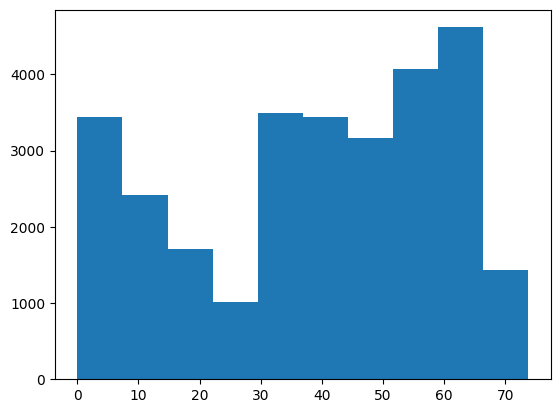

In [38]:
plt.hist(train_data['age_at_hct'])

In [39]:
train_data_cutID = train_data.drop(columns=['ID'])
target = train_data['y']

In [40]:
X=train_data_cutID.drop(['efs','efs_time','y'], axis=1)
# X = X.drop(['gvhd_proph'],axis=1)
X.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0


In [41]:
print(X.columns.tolist())

['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [42]:
X = pd.get_dummies(X,drop_first = False)
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X = X.rename(columns=new_names)
X.head()

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,dri_score_High,dri_score_HighTEDAMLcasemissingcytogenetics,dri_score_Intermediate,dri_score_IntermediateTEDAMLcasemissingcytogenetics,dri_score_Low,dri_score_Missingdiseasestatus,dri_score_NAdiseasenotclassifiable,dri_score_NAnonmalignantindication,dri_score_NApediatric,dri_score_TBDcytogenetics,dri_score_Veryhigh,psych_disturb_No,psych_disturb_Notdone,psych_disturb_Yes,cyto_score_Favorable,cyto_score_Intermediate,cyto_score_Normal,cyto_score_Nottested,cyto_score_Other,cyto_score_Poor,cyto_score_TBD,diabetes_No,diabetes_Notdone,diabetes_Yes,tbi_status_NoTBI,tbi_status_TBICyOther,tbi_status_TBIOthercGyfractionated,tbi_status_TBIOthercGysingle,tbi_status_TBIOthercGyunknowndose,tbi_status_TBIOthercGy,tbi_status_TBIOthercGy_52,tbi_status_TBIOtherunknowndose,arrhythmia_No,arrhythmia_Notdone,arrhythmia_Yes,graft_type_Bonemarrow,graft_type_Peripheralblood,vent_hist_No,vent_hist_Yes,renal_issue_No,renal_issue_Notdone,renal_issue_Yes,pulm_severe_No,pulm_severe_Notdone,pulm_severe_Yes,prim_disease_hct_AI,prim_disease_hct_ALL,prim_disease_hct_AML,prim_disease_hct_CML,prim_disease_hct_HD,prim_disease_hct_HIS,prim_disease_hct_IEA,prim_disease_hct_IIS,prim_disease_hct_IMD,prim_disease_hct_IPA,prim_disease_hct_MDS,prim_disease_hct_MPN,prim_disease_hct_NHL,prim_disease_hct_Otheracuteleukemia,prim_disease_hct_Otherleukemia,prim_disease_hct_PCD,prim_disease_hct_SAA,prim_disease_hct_Solidtumor,cmv_status_,cmv_status__86,cmv_status__87,cmv_status__88,tce_imm_match_GB,tce_imm_match_GG,tce_imm_match_HB,tce_imm_match_HH,tce_imm_match_PB,tce_imm_match_PG,tce_imm_match_PH,tce_imm_match_PP,rituximab_No,rituximab_Yes,prod_type_BM,prod_type_PB,cyto_score_detail_Favorable,cyto_score_detail_Intermediate,cyto_score_detail_Nottested,cyto_score_detail_Poor,cyto_score_detail_TBD,conditioning_intensity_MAC,conditioning_intensity_NAFpreTEDnotsubmitted,conditioning_intensity_NMA,conditioning_intensity_Nodrugsreported,conditioning_intensity_RIC,conditioning_intensity_TBD,ethnicity_HispanicorLatino,ethnicity_NonresidentoftheUS,ethnicity_NotHispanicorLatino,obesity_No,obesity_Notdone,obesity_Yes,mrd_hct_Negative,mrd_hct_Positive,in_vivo_tcd_No,in_vivo_tcd_Yes,tce_match_Fullymatched,tce_match_GvHnonpermissive,tce_match_HvGnonpermissive,tce_match_Permissive,hepatic_severe_No,hepatic_severe_Notdone,hepatic_severe_Yes,prior_tumor_No,prior_tumor_Notdone,prior_tumor_Yes,peptic_ulcer_No,peptic_ulcer_Notdone,peptic_ulcer_Yes,gvhd_proph_CDselectother,gvhd_proph_CDselectalone,gvhd_proph_CSAMMFothersnotFK,gvhd_proph_CSAMTXothersnotMMFFK,gvhd_proph_CSAothersnotFKMMFMTX,gvhd_proph_CSAalone,gvhd_proph_Cyclophosphamideothers,gvhd_proph_Cyclophosphamidealone,gvhd_proph_FKMMFothers,gvhd_proph_FKMTXothersnotMMF,gvhd_proph_FKothersnotMMFMTX,gvhd_proph_FKalone,gvhd_proph_NoGvHDProphylaxis,gvhd_proph_OtherGVHDProphylaxis,gvhd_proph_ParentQyesbutnoagent,gvhd_proph_TDEPLETIONother,gvhd_proph_TDEPLETIONalone,rheum_issue_No,rheum_issue_Notdone,rheum_issue_Yes,sex_match_FF,sex_match_FM,sex_match_MF,sex_match_MM,race_group_AmericanIndianorAlaskaNative,race_group_Asian,race_group_BlackorAfricanAmerican,race_group_Morethanonerace,race_group_NativeHawaiianorotherPacificIslander,race_group_White,hepatic_mild_No,hepatic_mild_Notdone,hepatic_mild_Yes,tce_div_match_Bidirectionalnonpermissive,tce_div_match_GvHnonpermissive,tce_div_match_HvGnonpermissive,tce_div_match_Permissivemismatched,donor_related_MultipledonornonUCB,donor_related_Related,donor_related_Unrelated,melphalan_dose_MEL,melphalan_dose_NAMelnotgiven,cardiac_No,cardiac_Notdone,cardiac_Yes,pulm_moderate_No,pulm_moderate_Notdone,pulm_moderate_Yes
0,NaN,NaN,6.0,6.0,NaN,2.0,6.0,2.0,2.0,2.0,2016,2.0,NaN,2.0

In [43]:
categorical_cols = X.select_dtypes(include=["object"]).columns
cols_numerical = X.select_dtypes(include=["float64","int64"]).columns

In [44]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures

numerical_cols = X[cols_numerical].columns
imputer = KNNImputer(n_neighbors=2)

numerical_data_after_imputation=imputer.fit_transform(X[numerical_cols])
X_imputed = []
X_imputed = pd.DataFrame(numerical_data_after_imputation,columns=numerical_cols, index=X.index)
X.loc[:, numerical_cols] = X_imputed

In [45]:
X.head()

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,dri_score_High,dri_score_HighTEDAMLcasemissingcytogenetics,dri_score_Intermediate,dri_score_IntermediateTEDAMLcasemissingcytogenetics,dri_score_Low,dri_score_Missingdiseasestatus,dri_score_NAdiseasenotclassifiable,dri_score_NAnonmalignantindication,dri_score_NApediatric,dri_score_TBDcytogenetics,dri_score_Veryhigh,psych_disturb_No,psych_disturb_Notdone,psych_disturb_Yes,cyto_score_Favorable,cyto_score_Intermediate,cyto_score_Normal,cyto_score_Nottested,cyto_score_Other,cyto_score_Poor,cyto_score_TBD,diabetes_No,diabetes_Notdone,diabetes_Yes,tbi_status_NoTBI,tbi_status_TBICyOther,tbi_status_TBIOthercGyfractionated,tbi_status_TBIOthercGysingle,tbi_status_TBIOthercGyunknowndose,tbi_status_TBIOthercGy,tbi_status_TBIOthercGy_52,tbi_status_TBIOtherunknowndose,arrhythmia_No,arrhythmia_Notdone,arrhythmia_Yes,graft_type_Bonemarrow,graft_type_Peripheralblood,vent_hist_No,vent_hist_Yes,renal_issue_No,renal_issue_Notdone,renal_issue_Yes,pulm_severe_No,pulm_severe_Notdone,pulm_severe_Yes,prim_disease_hct_AI,prim_disease_hct_ALL,prim_disease_hct_AML,prim_disease_hct_CML,prim_disease_hct_HD,prim_disease_hct_HIS,prim_disease_hct_IEA,prim_disease_hct_IIS,prim_disease_hct_IMD,prim_disease_hct_IPA,prim_disease_hct_MDS,prim_disease_hct_MPN,prim_disease_hct_NHL,prim_disease_hct_Otheracuteleukemia,prim_disease_hct_Otherleukemia,prim_disease_hct_PCD,prim_disease_hct_SAA,prim_disease_hct_Solidtumor,cmv_status_,cmv_status__86,cmv_status__87,cmv_status__88,tce_imm_match_GB,tce_imm_match_GG,tce_imm_match_HB,tce_imm_match_HH,tce_imm_match_PB,tce_imm_match_PG,tce_imm_match_PH,tce_imm_match_PP,rituximab_No,rituximab_Yes,prod_type_BM,prod_type_PB,cyto_score_detail_Favorable,cyto_score_detail_Intermediate,cyto_score_detail_Nottested,cyto_score_detail_Poor,cyto_score_detail_TBD,conditioning_intensity_MAC,conditioning_intensity_NAFpreTEDnotsubmitted,conditioning_intensity_NMA,conditioning_intensity_Nodrugsreported,conditioning_intensity_RIC,conditioning_intensity_TBD,ethnicity_HispanicorLatino,ethnicity_NonresidentoftheUS,ethnicity_NotHispanicorLatino,obesity_No,obesity_Notdone,obesity_Yes,mrd_hct_Negative,mrd_hct_Positive,in_vivo_tcd_No,in_vivo_tcd_Yes,tce_match_Fullymatched,tce_match_GvHnonpermissive,tce_match_HvGnonpermissive,tce_match_Permissive,hepatic_severe_No,hepatic_severe_Notdone,hepatic_severe_Yes,prior_tumor_No,prior_tumor_Notdone,prior_tumor_Yes,peptic_ulcer_No,peptic_ulcer_Notdone,peptic_ulcer_Yes,gvhd_proph_CDselectother,gvhd_proph_CDselectalone,gvhd_proph_CSAMMFothersnotFK,gvhd_proph_CSAMTXothersnotMMFFK,gvhd_proph_CSAothersnotFKMMFMTX,gvhd_proph_CSAalone,gvhd_proph_Cyclophosphamideothers,gvhd_proph_Cyclophosphamidealone,gvhd_proph_FKMMFothers,gvhd_proph_FKMTXothersnotMMF,gvhd_proph_FKothersnotMMFMTX,gvhd_proph_FKalone,gvhd_proph_NoGvHDProphylaxis,gvhd_proph_OtherGVHDProphylaxis,gvhd_proph_ParentQyesbutnoagent,gvhd_proph_TDEPLETIONother,gvhd_proph_TDEPLETIONalone,rheum_issue_No,rheum_issue_Notdone,rheum_issue_Yes,sex_match_FF,sex_match_FM,sex_match_MF,sex_match_MM,race_group_AmericanIndianorAlaskaNative,race_group_Asian,race_group_BlackorAfricanAmerican,race_group_Morethanonerace,race_group_NativeHawaiianorotherPacificIslander,race_group_White,hepatic_mild_No,hepatic_mild_Notdone,hepatic_mild_Yes,tce_div_match_Bidirectionalnonpermissive,tce_div_match_GvHnonpermissive,tce_div_match_HvGnonpermissive,tce_div_match_Permissivemismatched,donor_related_MultipledonornonUCB,donor_related_Related,donor_related_Unrelated,melphalan_dose_MEL,melphalan_dose_NAMelnotgiven,cardiac_No,cardiac_Notdone,cardiac_Yes,pulm_moderate_No,pulm_moderate_Notdone,pulm_moderate_Yes
0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2016,2.0,54.824

In [46]:
poly = PolynomialFeatures(degree=2, include_bias=False)


poly_features = poly.fit_transform(X[['age_at_hct', 'donor_age', 'comorbidity_score']])
poly_columns = ['age_at_hct_poly',
                'donor_age_poly',
                'comorbidity_score_poly', 
                'age_at_hct^2',
                'donor_age^2',
                'comorbidity_score^2', 
                'age_at_hct * donor_age',
                'age_at_hct * comorbidity_score',
                'donor_age * comorbidity_score']

poly_df = pd.DataFrame(poly_features, columns=poly_columns, index=X.index)
X = pd.concat([X, poly_df], axis=1)

X.head()

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,dri_score_High,dri_score_HighTEDAMLcasemissingcytogenetics,dri_score_Intermediate,dri_score_IntermediateTEDAMLcasemissingcytogenetics,dri_score_Low,dri_score_Missingdiseasestatus,dri_score_NAdiseasenotclassifiable,dri_score_NAnonmalignantindication,dri_score_NApediatric,dri_score_TBDcytogenetics,dri_score_Veryhigh,psych_disturb_No,psych_disturb_Notdone,psych_disturb_Yes,cyto_score_Favorable,cyto_score_Intermediate,cyto_score_Normal,cyto_score_Nottested,cyto_score_Other,cyto_score_Poor,cyto_score_TBD,diabetes_No,diabetes_Notdone,diabetes_Yes,tbi_status_NoTBI,tbi_status_TBICyOther,tbi_status_TBIOthercGyfractionated,tbi_status_TBIOthercGysingle,tbi_status_TBIOthercGyunknowndose,tbi_status_TBIOthercGy,tbi_status_TBIOthercGy_52,tbi_status_TBIOtherunknowndose,arrhythmia_No,arrhythmia_Notdone,arrhythmia_Yes,graft_type_Bonemarrow,graft_type_Peripheralblood,vent_hist_No,vent_hist_Yes,renal_issue_No,renal_issue_Notdone,renal_issue_Yes,pulm_severe_No,pulm_severe_Notdone,pulm_severe_Yes,prim_disease_hct_AI,prim_disease_hct_ALL,prim_disease_hct_AML,prim_disease_hct_CML,prim_disease_hct_HD,prim_disease_hct_HIS,prim_disease_hct_IEA,prim_disease_hct_IIS,prim_disease_hct_IMD,prim_disease_hct_IPA,prim_disease_hct_MDS,prim_disease_hct_MPN,prim_disease_hct_NHL,prim_disease_hct_Otheracuteleukemia,prim_disease_hct_Otherleukemia,prim_disease_hct_PCD,prim_disease_hct_SAA,prim_disease_hct_Solidtumor,cmv_status_,cmv_status__86,cmv_status__87,cmv_status__88,tce_imm_match_GB,tce_imm_match_GG,tce_imm_match_HB,tce_imm_match_HH,tce_imm_match_PB,tce_imm_match_PG,tce_imm_match_PH,tce_imm_match_PP,rituximab_No,rituximab_Yes,prod_type_BM,prod_type_PB,cyto_score_detail_Favorable,cyto_score_detail_Intermediate,cyto_score_detail_Nottested,cyto_score_detail_Poor,cyto_score_detail_TBD,conditioning_intensity_MAC,conditioning_intensity_NAFpreTEDnotsubmitted,conditioning_intensity_NMA,conditioning_intensity_Nodrugsreported,conditioning_intensity_RIC,conditioning_intensity_TBD,ethnicity_HispanicorLatino,ethnicity_NonresidentoftheUS,ethnicity_NotHispanicorLatino,obesity_No,obesity_Notdone,obesity_Yes,mrd_hct_Negative,mrd_hct_Positive,in_vivo_tcd_No,in_vivo_tcd_Yes,tce_match_Fullymatched,tce_match_GvHnonpermissive,tce_match_HvGnonpermissive,tce_match_Permissive,hepatic_severe_No,hepatic_severe_Notdone,hepatic_severe_Yes,prior_tumor_No,prior_tumor_Notdone,prior_tumor_Yes,peptic_ulcer_No,peptic_ulcer_Notdone,peptic_ulcer_Yes,gvhd_proph_CDselectother,gvhd_proph_CDselectalone,gvhd_proph_CSAMMFothersnotFK,gvhd_proph_CSAMTXothersnotMMFFK,gvhd_proph_CSAothersnotFKMMFMTX,gvhd_proph_CSAalone,gvhd_proph_Cyclophosphamideothers,gvhd_proph_Cyclophosphamidealone,gvhd_proph_FKMMFothers,gvhd_proph_FKMTXothersnotMMF,gvhd_proph_FKothersnotMMFMTX,gvhd_proph_FKalone,gvhd_proph_NoGvHDProphylaxis,gvhd_proph_OtherGVHDProphylaxis,gvhd_proph_ParentQyesbutnoagent,gvhd_proph_TDEPLETIONother,gvhd_proph_TDEPLETIONalone,rheum_issue_No,rheum_issue_Notdone,rheum_issue_Yes,sex_match_FF,sex_match_FM,sex_match_MF,sex_match_MM,race_group_AmericanIndianorAlaskaNative,race_group_Asian,race_group_BlackorAfricanAmerican,race_group_Morethanonerace,race_group_NativeHawaiianorotherPacificIslander,race_group_White,hepatic_mild_No,hepatic_mild_Notdone,hepatic_mild_Yes,tce_div_match_Bidirectionalnonpermissive,tce_div_match_GvHnonpermissive,tce_div_match_HvGnonpermissive,tce_div_match_Permissivemismatched,donor_related_MultipledonornonUCB,donor_related_Related,donor_related_Unrelated,melphalan_dose_MEL,melphalan_dose_NAMelnotgiven,cardiac_No,cardiac_Notdone,cardiac_Yes,pulm_moderate_No,pulm_moderate_Notdone,pulm_moderate_Yes,age_at_hct_poly,donor_age_poly,comorbidity_score_poly,age_

In [47]:
X_int = pd.Series()
X_int['age_at_hct_int']=X['age_at_hct'].astype(int)
X['age_sum'] = X['donor_age'].fillna(0) + X_int['age_at_hct_int'].fillna(0)
X['age_diff'] = abs(X['donor_age'].fillna(0) - X_int['age_at_hct_int'].fillna(0))
X['karnof/age'] = X['karnofsky_score'] / X_int['age_at_hct_int']
X['karnof/age'].clip(-1e6, 1e6, inplace=True)
# X['comorbidity/age'] = X['comorbidity_score'] / X_int['age_at_hct_int']
# X['comorbidity/age'].clip(-1e6, 1e6, inplace=True)
# X['hla_match_c_high_x_drb1_high'] = X['hla_match_c_high'] * X['hla_match_drb1_high']
X.head()

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,dri_score_High,dri_score_HighTEDAMLcasemissingcytogenetics,dri_score_Intermediate,dri_score_IntermediateTEDAMLcasemissingcytogenetics,dri_score_Low,dri_score_Missingdiseasestatus,dri_score_NAdiseasenotclassifiable,dri_score_NAnonmalignantindication,dri_score_NApediatric,dri_score_TBDcytogenetics,dri_score_Veryhigh,psych_disturb_No,psych_disturb_Notdone,psych_disturb_Yes,cyto_score_Favorable,cyto_score_Intermediate,cyto_score_Normal,cyto_score_Nottested,cyto_score_Other,cyto_score_Poor,cyto_score_TBD,diabetes_No,diabetes_Notdone,diabetes_Yes,tbi_status_NoTBI,tbi_status_TBICyOther,tbi_status_TBIOthercGyfractionated,tbi_status_TBIOthercGysingle,tbi_status_TBIOthercGyunknowndose,tbi_status_TBIOthercGy,tbi_status_TBIOthercGy_52,tbi_status_TBIOtherunknowndose,arrhythmia_No,arrhythmia_Notdone,arrhythmia_Yes,graft_type_Bonemarrow,graft_type_Peripheralblood,vent_hist_No,vent_hist_Yes,renal_issue_No,renal_issue_Notdone,renal_issue_Yes,pulm_severe_No,pulm_severe_Notdone,pulm_severe_Yes,prim_disease_hct_AI,prim_disease_hct_ALL,prim_disease_hct_AML,prim_disease_hct_CML,prim_disease_hct_HD,prim_disease_hct_HIS,prim_disease_hct_IEA,prim_disease_hct_IIS,prim_disease_hct_IMD,prim_disease_hct_IPA,prim_disease_hct_MDS,prim_disease_hct_MPN,prim_disease_hct_NHL,prim_disease_hct_Otheracuteleukemia,prim_disease_hct_Otherleukemia,prim_disease_hct_PCD,prim_disease_hct_SAA,prim_disease_hct_Solidtumor,cmv_status_,cmv_status__86,cmv_status__87,cmv_status__88,tce_imm_match_GB,tce_imm_match_GG,tce_imm_match_HB,tce_imm_match_HH,tce_imm_match_PB,tce_imm_match_PG,tce_imm_match_PH,tce_imm_match_PP,rituximab_No,rituximab_Yes,prod_type_BM,prod_type_PB,cyto_score_detail_Favorable,cyto_score_detail_Intermediate,cyto_score_detail_Nottested,cyto_score_detail_Poor,cyto_score_detail_TBD,conditioning_intensity_MAC,conditioning_intensity_NAFpreTEDnotsubmitted,conditioning_intensity_NMA,conditioning_intensity_Nodrugsreported,conditioning_intensity_RIC,conditioning_intensity_TBD,ethnicity_HispanicorLatino,ethnicity_NonresidentoftheUS,ethnicity_NotHispanicorLatino,obesity_No,obesity_Notdone,obesity_Yes,mrd_hct_Negative,mrd_hct_Positive,in_vivo_tcd_No,in_vivo_tcd_Yes,tce_match_Fullymatched,tce_match_GvHnonpermissive,tce_match_HvGnonpermissive,tce_match_Permissive,hepatic_severe_No,hepatic_severe_Notdone,hepatic_severe_Yes,prior_tumor_No,prior_tumor_Notdone,prior_tumor_Yes,peptic_ulcer_No,peptic_ulcer_Notdone,peptic_ulcer_Yes,gvhd_proph_CDselectother,gvhd_proph_CDselectalone,gvhd_proph_CSAMMFothersnotFK,gvhd_proph_CSAMTXothersnotMMFFK,gvhd_proph_CSAothersnotFKMMFMTX,gvhd_proph_CSAalone,gvhd_proph_Cyclophosphamideothers,gvhd_proph_Cyclophosphamidealone,gvhd_proph_FKMMFothers,gvhd_proph_FKMTXothersnotMMF,gvhd_proph_FKothersnotMMFMTX,gvhd_proph_FKalone,gvhd_proph_NoGvHDProphylaxis,gvhd_proph_OtherGVHDProphylaxis,gvhd_proph_ParentQyesbutnoagent,gvhd_proph_TDEPLETIONother,gvhd_proph_TDEPLETIONalone,rheum_issue_No,rheum_issue_Notdone,rheum_issue_Yes,sex_match_FF,sex_match_FM,sex_match_MF,sex_match_MM,race_group_AmericanIndianorAlaskaNative,race_group_Asian,race_group_BlackorAfricanAmerican,race_group_Morethanonerace,race_group_NativeHawaiianorotherPacificIslander,race_group_White,hepatic_mild_No,hepatic_mild_Notdone,hepatic_mild_Yes,tce_div_match_Bidirectionalnonpermissive,tce_div_match_GvHnonpermissive,tce_div_match_HvGnonpermissive,tce_div_match_Permissivemismatched,donor_related_MultipledonornonUCB,donor_related_Related,donor_related_Unrelated,melphalan_dose_MEL,melphalan_dose_NAMelnotgiven,cardiac_No,cardiac_Notdone,cardiac_Yes,pulm_moderate_No,pulm_moderate_Notdone,pulm_moderate_Yes,age_at_hct_poly,donor_age_poly,comorbidity_score_poly,age_

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Columns: 195 entries, hla_match_c_high to karnof/age
dtypes: bool(161), float64(33), int64(1)
memory usage: 11.9 MB


In [51]:
X_train,X_test,y_train,y_test=train_test_split(X,target,test_size=0.2,random_state=42)

In [52]:
best_lgbm_params = {'num_leaves': 12,
                    'max_depth': 10,
                    'learning_rate': 0.1,
                    'n_estimators': 128,
                    'subsample': 0.5,
                    'colsample_bytree': 0.6,
                    'reg_alpha': 0.4,
                    'reg_lambda': 0.3,
                    'min_child_samples': 20,
                    'min_split_gain': 0.5,
                    'max_bin': 128
                   }
best_xgb_params = {'xgb_max_depth': 12,
                   'xgb_learning_rate': 0.1,
                   'xgb_n_estimators': 240,
                   'xgb_subsample': 0.6,
                   'xgb_colsample_bytree': 0.9,
                   'xgb_reg_alpha': 0.4,
                   'xgb_reg_lambda': 0.3
                  }

lgbm_best = LGBMRegressor(**best_lgbm_params)
xgb_best = XGBRegressor(**best_xgb_params)

lgbm = LGBMRegressor(**best_lgbm_params)
lgbm.fit(X_train, y_train) 

xgb = XGBRegressor(**best_xgb_params)
xgb.fit(X_train, y_train)

final_voting_regressor = VotingRegressor(estimators=[
    ('lgbm', lgbm_best),
    ('xgb', xgb_best)
])

final_voting_regressor.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 190
[LightGBM] [Info] Start training from score 0.606473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(colsample_bytree=0.6, max_bin=128,
                                           max_depth=10, min_split_gain=0.5,
                                           n_estimators=128, num_leaves=12,
                                           reg_alpha=0.4, reg_lambda=0.3,
                                           subsample=0.5)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_r...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...))])

In [53]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
mse_scores = []
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(X_train):
    tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # final_voting_regressor = VotingRegressor(estimators=[
    # ('lgbm', lgbm_best),
    # ('xgb', xgb_best)
    # ])
    
    # final_voting_regressor.fit(tr_x, tr_y)
    y_pred = final_voting_regressor.predict(va_x)

    mse = mean_squared_error(va_y, y_pred)
    mse_scores.append(mse)

print(f"Average MSE: {np.mean(mse_scores):.4f}")

Average MSE: 0.0181


In [54]:
# sns.heatmap(X_train[['dri_score_High','comorbidity_score','donor_age','age_at_hct','cyto_score_detail_Poor','ethnicity_HispanicorLatino', 'ethnicity_NonresidentoftheUS', 'ethnicity_NotHispanicorLatino']].corr())

In [55]:
# import xgboost as xgbdm
# dtrain = xgbdm.DMatrix(X_train, label=y_train)
# params = {'objective': 'binary:logistic', 'silent': 1, 'random_state': 71}
# num_round = 50
# model = xgbdm.train(params, dtrain, num_round)

In [56]:
# fscore = model.get_score(importance_type='total_gain')
# fscore = sorted([(k, v) for k, v in fscore.items()], key=lambda tpl: tpl[1], reverse=True)
# print('xgboost importance')
# print(fscore[:5])

In [57]:
test_data_cutID=test_data.drop(['ID'], axis=1)
test_df = pd.get_dummies(test_data_cutID,drop_first = False)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in test_df.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
test_df = test_df.rename(columns=new_names)

In [58]:
missing_columns = set(tr_x.columns) - set(test_df.columns)

for col in missing_columns:
    test_df[col] = np.nan

test_df = test_df[tr_x.columns]

In [59]:
# missing_columns
test_categorical_cols = test_df.select_dtypes(include=["object"]).columns
test_cols_numerical = test_df.select_dtypes(include=["float64","int64"]).columns

In [60]:
# test_numerical_cols = test_df[test_cols_numerical].columns
# test_imputer = KNNImputer(n_neighbors=2)

# test_numerical_data_after_imputation=test_imputer.fit_transform(test_df[test_numerical_cols])
# test_df_imputed = []
# test_df_imputed = pd.DataFrame(test_numerical_data_after_imputation,columns=test_numerical_cols, index=test_df.index)
# test_df.loc[:, numerical_cols] = test_df_imputed

In [61]:
test_int = pd.Series()
test_int['age_at_hct_int']=test_df['age_at_hct'].astype(int)
test_df['age_sum'] = test_df['donor_age'].fillna(0) + test_int['age_at_hct_int'].fillna(0)
test_df['age_diff'] = abs(test_df['donor_age'].fillna(0) - test_int['age_at_hct_int'].fillna(0))
test_df['karnof/age'] = test_df['karnofsky_score'] / test_int['age_at_hct_int']
# test_df['hla_match_c_high_x_drb1_high'] = test_df['hla_match_c_high'] * test_df['hla_match_drb1_high']
test_df['karnof/age'].clip(-1e6, 1e6, inplace=True)
# test_df['comorbidity/age'] = test_df['comorbidity_score'] / test_int['age_at_hct_int']
# test_df['comorbidity/age'].clip(-1e6, 1e6, inplace=True)

In [62]:
test_numerical_cols = test_df[cols_numerical].columns
imputer = KNNImputer(n_neighbors=2)

test_numerical_data_after_imputation=imputer.fit_transform(test_df[numerical_cols])
test_df_imputed = []
test_df_imputed = pd.DataFrame(test_numerical_data_after_imputation,columns=test_numerical_cols, index=test_df.index)
test_df.loc[:, numerical_cols] = test_df_imputed

In [63]:
test_imputed = []
test_imputed = pd.DataFrame(test_numerical_data_after_imputation,columns=test_numerical_cols, index=test_df.index)
test_poly = PolynomialFeatures(degree=2, include_bias=False)


test_poly_features = test_poly.fit_transform(test_imputed[['age_at_hct', 'donor_age', 'comorbidity_score']])
test_poly_columns = ['age_at_hct_poly', 'donor_age_poly', 'comorbidity_score_poly', 
                'age_at_hct^2', 'donor_age^2', 'comorbidity_score^2', 
                'age_at_hct * donor_age', 'age_at_hct * comorbidity_score', 'donor_age * comorbidity_score']
test_poly_df = pd.DataFrame(test_poly_features, columns=test_poly_columns, index=test_df.index)
test_df[test_poly_columns] = test_poly_df[test_poly_columns]

In [64]:
bool_cols = tr_x.select_dtypes(include=['bool']).columns
test_df[bool_cols] = test_df[bool_cols].fillna(False).astype(bool)

In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Columns: 195 entries, hla_match_c_high to karnof/age
dtypes: bool(161), float64(33), int64(1)
memory usage: 1.4 KB


In [66]:
submission_gb = pd.DataFrame()
submission_gb['ID'] = test_data['ID']

submission_gb['prediction'] = final_voting_regressor.predict(test_df)
file_name = 'submission.csv'
# submission_gb.to_csv(file_name, index=False)
submission_gb

,ID,prediction
0,28800,0.617810
1,28801,0.652196
2,28802,0.534803
